In [1]:
%pip install -U transformers

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Вадим\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
%pip install -Uq transformers.utils

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement transformers.utils (from versions: none)
ERROR: No matching distribution found for transformers.utils
You should consider upgrading via the 'c:\Users\Вадим\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('russian'))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Вадим\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import torch
import random
import numpy as np
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import load_metric, Dataset
from sklearn.metrics import classification_report, f1_score



c:\Users\Вадим\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


In [6]:
%pip install tqdm
import tqdm

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Вадим\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [7]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Вадим\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [8]:
%pip install tensorflow keras

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Вадим\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPool1D, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
num_words = 10000
max_review_len = 100

In [11]:
data = pd.read_csv('banks.csv', sep='\t', comment='#')
data.head()

,idx,Score,Text
0,0,Positive,В Альфа-Банке работает замечательная девушка -...
1,1,Negative,Оформляя рассрочку в м. Видео в меге тёплый ст...
2,2,Positive,Очень порадовала оперативность работы в банке....
3,3,Negative,Имела неосторожность оформить потреб. кредит в...
4,4,Negative,Небольшая предыстория: Нашел на сайте MDM банк...


In [12]:
data.Score.replace("Positive", 1, inplace=True)
data.Score.replace("Negative", 2, inplace=True)
data.head()

,idx,Score,Text
0,0,1,В Альфа-Банке работает замечательная девушка -...
1,1,2,Оформляя рассрочку в м. Видео в меге тёплый ст...
2,2,1,Очень порадовала оперативность работы в банке....
3,3,2,Имела неосторожность оформить потреб. кредит в...
4,4,2,Небольшая предыстория: Нашел на сайте MDM банк...


In [13]:
stemmer = SnowballStemmer('russian')
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return " ".join(text)

In [14]:
def data_processing(text):
    text= text.lower()
    text = re.sub('<br />', '', text)
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return filtered_text

In [15]:
def num_of_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [16]:
data['word count'] = data['Text'].apply(num_of_words)
data.head()

,idx,Score,Text,word count
0,0,1,В Альфа-Банке работает замечательная девушка -...,110
1,1,2,Оформляя рассрочку в м. Видео в меге тёплый ст...,273
2,2,1,Очень порадовала оперативность работы в банке....,177
3,3,2,Имела неосторожность оформить потреб. кредит в...,155
4,4,2,Небольшая предыстория: Нашел на сайте MDM банк...,548


In [17]:
data.Text = data['Text'].apply(data_processing)
data.head()

,idx,Score,Text,word count
0,0,1,"[альфабанке, работает, замечательная, девушка,...",110
1,1,2,"[оформляя, рассрочку, м, видео, меге, тёплый, ...",273
2,2,1,"[очень, порадовала, оперативность, работы, бан...",177
3,3,2,"[имела, неосторожность, оформить, потреб, кред...",155
4,4,2,"[небольшая, предыстория, нашел, сайте, mdm, ба...",548


In [18]:
data = data.drop_duplicates('Text')


In [19]:
data.Text = data['Text'].apply(lambda x: stemming(x))


In [20]:
data.head()

,idx,Score,Text,word count
0,0,1,альфабанк работа замечательн девушк ильясов ор...,110
1,1,2,оформл рассрочк м виде мег тепл стан попрос ме...,273
2,2,1,очен порадова оперативн работ банк заказа инте...,177
3,3,2,имел неосторожн оформ потреб кред альфабанк оч...,155
4,4,2,небольш предыстор нашел сайт mdm банк интересн...,548


In [21]:
pos_scores = data[data.Score == 1]

In [22]:
count = Counter()
for text in pos_scores['Text'].values:
    for word in text.split():
        count[word] +=1
count.most_common(15)

[('банк', 26071),
 ('карт', 12398),
 ('эт', 8836),
 ('очен', 6952),
 ('отделен', 6256),
 ('котор', 6077),
 ('сотрудник', 5983),
 ('мо', 5900),
 ('клиент', 5777),
 ('вопрос', 4702),
 ('счет', 4616),
 ('сво', 4435),
 ('офис', 4004),
 ('деньг', 3924),
 ('работ', 3857)]

In [23]:
data['word count'] = data['Text'].apply(num_of_words)
data.head()

,idx,Score,Text,word count
0,0,1,альфабанк работа замечательн девушк ильясов ор...,69
1,1,2,оформл рассрочк м виде мег тепл стан попрос ме...,147
2,2,1,очен порадова оперативн работ банк заказа инте...,113
3,3,2,имел неосторожн оформ потреб кред альфабанк оч...,93
4,4,2,небольш предыстор нашел сайт mdm банк интересн...,338


In [24]:
pos_texts = data[data.Score == 1]
pos_texts.head()

,idx,Score,Text,word count
0,0,1,альфабанк работа замечательн девушк ильясов ор...,69
2,2,1,очен порадова оперативн работ банк заказа инте...,113
5,5,1,конц феврал оформ кредитн карт банк авангард к...,95
10,10,1,год назад получ кредитк выбра банк изз стоимос...,126
11,11,1,отделен автозаводск 01072015 пополня карточк б...,24


In [25]:
count = Counter()
for text in pos_texts['Text'].values:
    for word in text.split():
        count[word] +=1
count.most_common(15)

[('банк', 26071),
 ('карт', 12398),
 ('эт', 8836),
 ('очен', 6952),
 ('отделен', 6256),
 ('котор', 6077),
 ('сотрудник', 5983),
 ('мо', 5900),
 ('клиент', 5777),
 ('вопрос', 4702),
 ('счет', 4616),
 ('сво', 4435),
 ('офис', 4004),
 ('деньг', 3924),
 ('работ', 3857)]

In [26]:
pos_texts = pd.DataFrame(count.most_common(15))
pos_texts.columns = ['word', 'count']
pos_texts.head(15)

,word,count
0,банк,26071
1,карт,12398
2,эт,8836
3,очен,6952
4,отделен,6256
5,котор,6077
6,сотрудник,5983
7,мо,5900
8,клиент,5777
9,вопрос,4702


In [27]:
neg_texts = data[data.Score == 2]
neg_texts.head()

,idx,Score,Text,word count
1,1,2,оформл рассрочк м виде мег тепл стан попрос ме...,147
3,3,2,имел неосторожн оформ потреб кред альфабанк оч...,93
4,4,2,небольш предыстор нашел сайт mdm банк интересн...,338
6,6,2,месяц назад взял автокред ход разн салон форд ...,248
7,7,2,говор махинац бонус остановл процент среднемес...,86


In [28]:
count = Counter()
for text in neg_texts['Text'].values:
    for word in text.split():
        count[word] +=1
count.most_common(15)

[('банк', 31386),
 ('карт', 17814),
 ('эт', 11947),
 ('мо', 9693),
 ('счет', 8944),
 ('котор', 8364),
 ('сотрудник', 8336),
 ('отделен', 7046),
 ('клиент', 6674),
 ('деньг', 6519),
 ('ответ', 6376),
 ('сказа', 6229),
 ('сумм', 5925),
 ('дан', 5808),
 ('сво', 5152)]

In [29]:
neg_texts = pd.DataFrame(count.most_common(15))
neg_texts.columns = ['word', 'count']
neg_texts.head()

,word,count
0,банк,31386
1,карт,17814
2,эт,11947
3,мо,9693
4,счет,8944


In [30]:
X = data['Text']
Y = data['Score']


In [31]:
vect = TfidfVectorizer()
X = vect.fit_transform(data['Text'])

In [32]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = .3)

In [33]:
log_regression = LogisticRegression()
log_regression.fit(x_train, y_train)
log_predict = log_regression.predict(x_test)
log_accuracy = accuracy_score(log_predict, y_test)
print("Итак модель акинатор на: {:.1%}".format(log_accuracy))

Итак модель акинатор на: 95.2%


In [34]:
%pip install datasets

You should consider upgrading via the 'c:\Users\Вадим\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [35]:
train_d = data.iloc[:12000]
test_d = data.iloc[12000:]

In [36]:
x_train_d = train_d['Text']
y_train_d = train_d['Score'] - 1

In [37]:
texts = x_train_d

In [38]:
tokenizer = Tokenizer(num_words=num_words)

In [39]:
tokenizer.fit_on_texts(texts)

In [40]:
sequences = tokenizer.texts_to_sequences(texts)

In [41]:
x_train_d = pad_sequences(sequences, maxlen=max_review_len)

In [42]:
model = Sequential()
model.add(Embedding(num_words, 64, input_length=max_review_len))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [43]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 96, 250)           80250     
                                                                 
 global_max_pooling1d (Glob  (None, 250)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               32128     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [45]:
history = model.fit(x_train_d, 
                    y_train_d, 
                    epochs=4,
                    batch_size=128,
                    validation_split=0.1)

Epoch 1/4


85/85 [==============================] - 9s 94ms/step - loss: 0.4923 - accuracy: 0.7510 - val_loss: 0.2471 - val_accuracy: 0.9108
Epoch 2/4
85/85 [==============================] - 6s 74ms/step - loss: 0.1640 - accuracy: 0.9405 - val_loss: 0.1831 - val_accuracy: 0.9308
Epoch 3/4
85/85 [==============================] - 7s 79ms/step - loss: 0.0717 - accuracy: 0.9782 - val_loss: 0.2139 - val_accuracy: 0.9208
Epoch 4/4
85/85 [==============================] - 6s 73ms/step - loss: 0.0267 - accuracy: 0.9937 - val_loss: 0.2426 - val_accuracy: 0.9208


In [46]:
import matplotlib.pyplot as plt
%matplotlib inline 

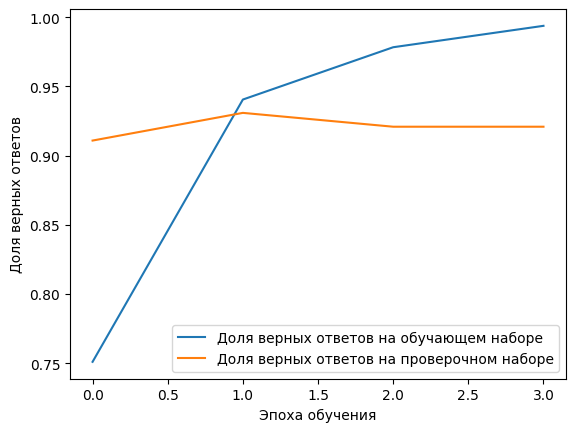

In [47]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [48]:
test_sequences = tokenizer.texts_to_sequences(test_d['Text'])

In [49]:
x_test = pad_sequences(test_sequences, maxlen=max_review_len)

In [50]:
y_test = test_d['Score'] - 1

In [51]:
y_test

12002    1
12003    1
12004    0
12005    1
12006    0
        ..
13994    0
13995    0
13996    0
13997    0
13998    1
Name: Score, Length: 1996, dtype: int64

In [52]:
model.evaluate(x_test, y_test, verbose=1)

 1/63 [..............................] - ETA: 4s - loss: 0.2935 - accuracy: 0.9062

63/63 [==============================] - 0s 5ms/step - loss: 0.2079 - accuracy: 0.9349


[0.20791876316070557, 0.9348697662353516]

In [53]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
seed_all(42)

Применение трансформера для классификации текстов

In [54]:
model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
x_train = train_d['Text'].astype('str')

In [56]:
x_test = test_d['Text'].astype('str')

In [57]:
train_label = train_d['Score'] - 1
test_label = test_d['Score'] - 1

In [58]:
seq_len_train = [len(str(i).split()) for i in train_d['Text']]
seq_len_test = [len(str(i).split()) for i in test_d['Text']]
max_seq_len = max(max(seq_len_test), max(seq_len_train))
max_seq_len

2392

In [59]:
tokens_train = tokenizer.batch_encode_plus(
    x_train.values,
    max_length = 512,
    padding = True,
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    x_test.values,
    max_length = 512,
    padding = True,
    truncation = True
)

In [60]:
class Data(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item
    def __len__(self):
        return len(self.labels)
    
train_dataset = Data(tokens_train, train_label)
test_dataset = Data(tokens_test, test_label)

In [61]:
from sklearn.metrics import f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds)
    return {'F1': f1}

In [62]:
%pip install accelerate -Uq

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Вадим\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [63]:
%pip install -q transformers[torch]

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Вадим\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [64]:
%pip install accelerate -U
%pip install transformers[torch]

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Вадим\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Вадим\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [65]:
training_args = TrainingArguments(
    output_dir = './results', #Выходной каталог
    num_train_epochs = 3, #Кол-во эпох для обучения
    per_device_train_batch_size = 8, #Размер пакета для каждого устройства во время обучения
    per_device_eval_batch_size = 8, #Размер пакета для каждого устройства во время валидации
    weight_decay =0.01, #Понижение весов
    logging_dir = './logs', #Каталог для хранения журналов
    load_best_model_at_end = True, #Загружать ли лучшую модель после обучения
    learning_rate = 1e-5, #Скорость обучения
    evaluation_strategy ='epoch', #Валидация после каждой эпохи (можно сделать после конкретного кол-ва шагов)
    logging_strategy = 'epoch', #Логирование после каждой эпохи
    save_strategy = 'epoch', #Сохранение после каждой эпохи
    save_total_limit = 1,
    seed=21)

In [66]:
trainer = Trainer(model=model,
                  tokenizer = tokenizer,
                  args = training_args,
                  train_dataset = train_dataset,
                  eval_dataset = train_dataset,
                  compute_metrics = compute_metrics)

In [68]:
trainer.train()

FailedPreconditionError: . is not a directory